In [2]:
import tensorflow_hub as hub
import numpy as np
import os
import cv2
import csv
import matplotlib.pyplot as plt

# Load MoveNet Thunder model from TensorFlow Hub
model_url = "https://tfhub.dev/google/movenet/singlepose/thunder/4"
movenet = hub.load(model_url)

print("MoveNet Thunder model loaded successfully.")

2024-07-10 16:11:56.813562: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


MoveNet Thunder model loaded successfully.


In [3]:
image_path = '../data/images/boat.Boat_Pose_01.jpeg'
# Function to load and preprocess image while maintaining aspect ratio
def load_and_preprocess_image(image_path):
    # Read the image from file
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be read.")
    # Convert image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize the image to maintain aspect ratio and fit within 256x256
    h, w, _ = image.shape
    scale = 256 / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized_image = cv2.resize(image, (new_w, new_h))
    # Pad the resized image to be 256x256
    pad_h = (256 - new_h) // 2
    pad_w = (256 - new_w) // 2
    padded_image = cv2.copyMakeBorder(resized_image, pad_h, 256 - new_h - pad_h, pad_w, 256 - new_w - pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    # Normalize the image to [0,1]
    padded_image = padded_image.astype(np.float32) / 255.0
    return padded_image

In [4]:
# Function to detect keypoints
def detect_keypoints(image):
    input_image = tf.convert_to_tensor(image, dtype=tf.int32)
    input_image = tf.expand_dims(input_image, axis=0)
    outputs = movenet.signatures['serving_default'](input_image)
    keypoints = outputs['output_0'].numpy().reshape(-1)
    return keypoints

In [5]:
# Function to save keypoints with class name to CSV
def save_keypoints_with_class(keypoints, class_name, keypoints_path, headers):
    file_exists = os.path.isfile(keypoints_path)
    with open(keypoints_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(headers)
        row = [class_name] + keypoints.tolist()
        writer.writerow(row)

In [6]:
# Function to plot keypoints on image
def plot_keypoints(image, keypoints, threshold=0.5):
    plt.imshow(image)
    h, w, _ = image.shape
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        if conf > threshold:  # Only plot keypoints with high confidence
            plt.scatter(x * w, y * h, s=20, c='r', marker='o')  # Adjust coordinates to image scale
    plt.axis('off')
    plt.show()

In [ ]:
# Base directory where images are stored
images_base_dir = '../data/images'
# Directory to save keypoints
keypoints_base_dir = '../data/keypoints'
os.makedirs(keypoints_base_dir, exist_ok=True)

# Headers for the CSV file
headers = ["Class",
           "Nose_x", "Nose_y", "Nose_conf",
           "LeftEye_x", "LeftEye_y", "LeftEye_conf",
           "RightEye_x", "RightEye_y", "RightEye_conf",
           "LeftEar_x", "LeftEar_y", "LeftEar_conf",
           "RightEar_x", "RightEar_y", "RightEar_conf",
           "LeftShoulder_x", "LeftShoulder_y", "LeftShoulder_conf",
           "RightShoulder_x", "RightShoulder_y", "RightShoulder_conf",
           "LeftElbow_x", "LeftElbow_y", "LeftElbow_conf",
           "RightElbow_x", "RightElbow_y", "RightElbow_conf",
           "LeftWrist_x", "LeftWrist_y", "LeftWrist_conf",
           "RightWrist_x", "RightWrist_y", "RightWrist_conf",
           "LeftHip_x", "LeftHip_y", "LeftHip_conf",
           "RightHip_x", "RightHip_y", "RightHip_conf",
           "LeftKnee_x", "LeftKnee_y", "LeftKnee_conf",
           "RightKnee_x", "RightKnee_y", "RightKnee_conf",
           "LeftAnkle_x", "LeftAnkle_y", "LeftAnkle_conf",
           "RightAnkle_x", "RightAnkle_y", "RightAnkle_conf"]

# Function to process all images and extract keypoints
def process_images_and_extract_keypoints():
    for class_folder in os.listdir(images_base_dir):
        class_folder_path = os.path.join(images_base_dir, class_folder)
        if os.path.isdir(class_folder_path):
            class_name = class_folder
            image_plotted = False  # Variable to track if an image has been plotted for the current class
            for file in os.listdir(class_folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_folder_path, file)
                    keypoints_path = os.path.join(keypoints_base_dir, class_name + '.csv')
                    os.makedirs(os.path.dirname(keypoints_path), exist_ok=True)

                    try:
                        # Load and preprocess image
                        image = load_and_preprocess_image(image_path)
                        # Extract keypoints
                        keypoints = detect_keypoints(image)
                        # Save keypoints with class name to a file
                        save_keypoints_with_class(keypoints, class_name, keypoints_path, headers)
                        print(f"Processed {image_path}, saved keypoints to {keypoints_path}")
                        
                        # Plot keypoints on image for the first image per class
                        if not image_plotted:
                            plot_keypoints(image, keypoints)
                            image_plotted = True  # Set the flag to True after plotting the first image
                            break  # Break out of the loop to ensure only one image is plotted per class
                    except Exception as e:
                        print(f"Error processing {image_path}: {e}")

# Process all images
process_images_and_extract_keypoints()

Loading MoveNet Thunder model...
MoveNet Thunder model loaded successfully.
Loading image from path: ../data/images/Boat/Boat_Pose_01.jpeg
Image loaded successfully.
Image converted to RGB.
Original image size: 236x354
Resized image to: 170x256
Image padded to 256x256.
Image normalized to [0, 1].
Converting image to tensor...
Running MoveNet Thunder model...
Keypoints detected.

Keypoints before conversion to original size:
Keypoint 0: (x: 0.29204803705215454, y: 0.522662878036499, confidence: 0.0016322472365573049)
Keypoint 1: (x: 0.39491379261016846, y: 0.5019137263298035, confidence: 0.001968247815966606)
Keypoint 2: (x: 0.23811966180801392, y: 0.49085745215415955, confidence: 0.0003333893546368927)
Keypoint 3: (x: 0.5855638980865479, y: 0.36809810996055603, confidence: 0.01373362448066473)
Keypoint 4: (x: 0.6132163405418396, y: 0.5794877409934998, confidence: 0.009060356765985489)
Keypoint 5: (x: 0.3861183822154999, y: 0.5642606616020203, confidence: 0.004699320066720247)
Keypoint 

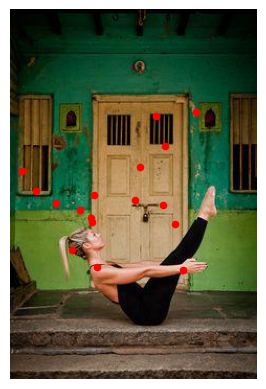

Keypoints plotted.


In [25]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load MoveNet Thunder model from TensorFlow Hub
model_url = "https://tfhub.dev/google/movenet/singlepose/thunder/4"
print("Loading MoveNet Thunder model...")
movenet = hub.load(model_url)
print("MoveNet Thunder model loaded successfully.")

# Function to load and preprocess image while maintaining aspect ratio
def load_and_preprocess_image(image_path):
    print(f"Loading image from path: {image_path}")
    # Read the image from file
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be read.")
    print("Image loaded successfully.")
    
    # Convert image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("Image converted to RGB.")
    
    # Get original image dimensions
    original_h, original_w, _ = image.shape
    print(f"Original image size: {original_w}x{original_h}")
    
    # Resize the image to maintain aspect ratio and fit within 256x256
    input_size = 256
    scale = input_size / max(original_h, original_w)
    new_h, new_w = int(original_h * scale), int(original_w * scale)
    resized_image = cv2.resize(image, (new_w, new_h))
    print(f"Resized image to: {new_w}x{new_h}")
    
    # Pad the resized image to be 256x256
    pad_h = (input_size - new_h) // 2
    pad_w = (input_size - new_w) // 2
    padded_image = cv2.copyMakeBorder(resized_image, pad_h, input_size - new_h - pad_h, pad_w, input_size - new_w - pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    print("Image padded to 256x256.")
    
    # Normalize the image to [0,1]
    padded_image = padded_image.astype(np.float32) / 255.0
    print("Image normalized to [0, 1].")
    
    return padded_image, original_h, original_w, pad_h, pad_w, scale

# Function to detect keypoints
def detect_keypoints(image):
    print("Converting image to tensor...")
    input_image = tf.convert_to_tensor(image, dtype=tf.int32)
    input_image = tf.expand_dims(input_image, axis=0)
    print("Running MoveNet Thunder model...")
    outputs = movenet.signatures['serving_default'](input_image)
    keypoints = outputs['output_0'].numpy().reshape(-1)
    print("Keypoints detected.")
    return keypoints

# Function to plot keypoints on image
def plot_keypoints(original_image, keypoints, original_h, original_w, pad_h, pad_w, scale, threshold=0):
    print("Plotting keypoints on image...")
    plt.imshow(original_image)
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        print(f"Keypoint {i//3}: (x: {x}, y: {y}, confidence: {conf})")
        if conf > threshold:  # Only plot keypoints with high confidence
            # Map keypoints back to the original image dimensions
            x = (x * 256 - pad_w) / scale
            y = (y * 256 - pad_h) / scale
            plt.scatter(x, y, s=20, c='r', marker='o')
    plt.axis('off')
    plt.show()
    print("Keypoints plotted.")

# Function to print keypoints before and after conversion
def print_keypoints(keypoints, original_h, original_w, pad_h, pad_w, scale):
    print("\nKeypoints before conversion to original size:")
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        print(f"Keypoint {i//3}: (x: {x}, y: {y}, confidence: {conf})")
        
    print("\nKeypoints after conversion to original size:")
    converted_keypoints = []
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        x = (x * 256 - pad_w) / scale
        y = (y * 256 - pad_h) / scale
        converted_keypoints.extend([x, y, conf])
        print(f"Keypoint {i//3}: (x: {x}, y: {y}, confidence: {conf})")
    return np.array(converted_keypoints)

# Path to the image
image_path = '../data/images/Boat/Boat_Pose_01.jpeg'

# Load and preprocess image
image, original_h, original_w, pad_h, pad_w, scale = load_and_preprocess_image(image_path)

# Extract keypoints
keypoints = detect_keypoints(image)

# Print keypoints before and after conversion to original size
converted_keypoints = print_keypoints(keypoints, original_h, original_w, pad_h, pad_w, scale)

# Plot keypoints on image
plot_keypoints(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), keypoints, original_h, original_w, pad_h, pad_w, scale)


Loading MoveNet Thunder model...
MoveNet Thunder model loaded successfully.
Loading image from path: ../data/images/Boat/Boat_Pose_01.jpeg
Image loaded successfully.
Image converted to RGB.
Original image size: 236x354
Resized image to: 170x256
Image padded to 256x256 with pad_w=43 and pad_h=0.
Image normalized to [0, 1].
Converting image to tensor...
Running MoveNet Thunder model...
Keypoints detected.

Keypoints before conversion to original size:
Keypoint 0: (x: 0.29204803705215454, y: 0.522662878036499, confidence: 0.0016322472365573049)
Keypoint 1: (x: 0.39491379261016846, y: 0.5019137263298035, confidence: 0.001968247815966606)
Keypoint 2: (x: 0.23811966180801392, y: 0.49085745215415955, confidence: 0.0003333893546368927)
Keypoint 3: (x: 0.5855638980865479, y: 0.36809810996055603, confidence: 0.01373362448066473)
Keypoint 4: (x: 0.6132163405418396, y: 0.5794877409934998, confidence: 0.009060356765985489)
Keypoint 5: (x: 0.3861183822154999, y: 0.5642606616020203, confidence: 0.004

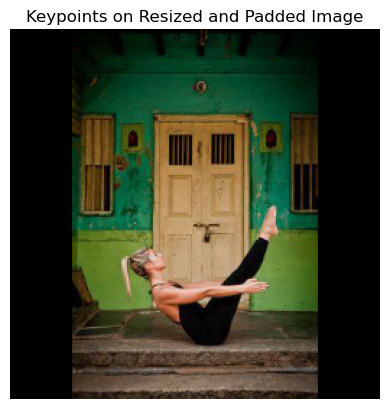

Keypoints plotted.
Plotting keypoints on Keypoints on Original Image image...
Keypoint 0: (x: 43.92406761646271, y: 185.02265882492065, confidence: 0.0016322472365573049)
Keypoint 1: (x: 80.33854508399963, y: 177.67745912075043, confidence: 0.001968247815966606)
Keypoint 2: (x: 24.833422780036926, y: 173.76353806257248, confidence: 0.0003333893546368927)
Keypoint 3: (x: 147.82868242263794, y: 130.30673092603683, confidence: 0.01373362448066473)
Keypoint 4: (x: 157.61764705181122, y: 205.1386603116989, confidence: 0.009060356765985489)
Keypoint 5: (x: 77.22496980428696, y: 199.74827420711517, confidence: 0.004699320066720247)
Keypoint 6: (x: 11.155229419469833, y: 154.3910493850708, confidence: 0.00461263582110405)
Keypoint 7: (x: 58.9684202671051, y: 230.07777321338654, confidence: 0.004899290390312672)
Keypoint 8: (x: 66.62802118062973, y: 191.66980576515198, confidence: 0.006420934572815895)
Keypoint 9: (x: 82.56245809793472, y: 246.55104196071625, confidence: 0.00385787314735353)
Ke

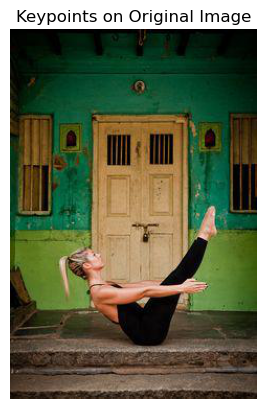

Keypoints plotted.


In [28]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load MoveNet Thunder model from TensorFlow Hub
model_url = "https://tfhub.dev/google/movenet/singlepose/thunder/4"
print("Loading MoveNet Thunder model...")
movenet = hub.load(model_url)
print("MoveNet Thunder model loaded successfully.")

# Function to load and preprocess image while maintaining aspect ratio
def load_and_preprocess_image(image_path):
    print(f"Loading image from path: {image_path}")
    # Read the image from file
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be read.")
    print("Image loaded successfully.")
    
    # Convert image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("Image converted to RGB.")
    
    # Get original image dimensions
    original_h, original_w, _ = image.shape
    print(f"Original image size: {original_w}x{original_h}")
    
    # Resize the image to maintain aspect ratio and fit within 256x256
    input_size = 256
    if original_h > original_w:
        new_h = input_size
        new_w = int(input_size * original_w / original_h)
    else:
        new_w = input_size
        new_h = int(input_size * original_h / original_w)
    
    resized_image = cv2.resize(image, (new_w, new_h))
    print(f"Resized image to: {new_w}x{new_h}")
    
    # Pad the resized image to be 256x256
    pad_h = (input_size - new_h) // 2
    pad_w = (input_size - new_w) // 2
    padded_image = cv2.copyMakeBorder(resized_image, pad_h, input_size - new_h - pad_h, pad_w, input_size - new_w - pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    print(f"Image padded to 256x256 with pad_w={pad_w} and pad_h={pad_h}.")
    
    # Normalize the image to [0,1]
    padded_image = padded_image.astype(np.float32) / 255.0
    print("Image normalized to [0, 1].")
    
    return padded_image, original_h, original_w, pad_h, pad_w, scale, resized_image, pad_w, pad_h

# Function to detect keypoints
def detect_keypoints(image):
    print("Converting image to tensor...")
    input_image = tf.convert_to_tensor(image, dtype=tf.int32)
    input_image = tf.expand_dims(input_image, axis=0)
    print("Running MoveNet Thunder model...")
    outputs = movenet.signatures['serving_default'](input_image)
    keypoints = outputs['output_0'].numpy().reshape(-1)
    print("Keypoints detected.")
    return keypoints

# Function to convert keypoints to original image size
def convert_keypoints(keypoints, original_h, original_w, pad_h, pad_w, scale):
    converted_keypoints = []
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        x = (x * 256 - pad_w) / scale
        y = (y * 256 - pad_h) / scale
        converted_keypoints.extend([x, y, conf])
    return np.array(converted_keypoints)

# Function to plot keypoints on image
def plot_keypoints(image, keypoints, title, threshold=0.3):
    print(f"Plotting keypoints on {title} image...")
    plt.imshow(image)
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        print(f"Keypoint {i//3}: (x: {x}, y: {y}, confidence: {conf})")
        if conf > threshold:  # Only plot keypoints with high confidence
            plt.scatter(x, y, s=20, c='r', marker='o')
    plt.title(title)
    plt.axis('off')
    plt.show()
    print("Keypoints plotted.")

# Path to the image
image_path = '../data/images/Boat/Boat_Pose_01.jpeg'

# Load and preprocess image
image, original_h, original_w, pad_h, pad_w, scale, resized_image, pad_w, pad_h = load_and_preprocess_image(image_path)

# Extract keypoints
keypoints = detect_keypoints(image)

# Convert keypoints to original image size
converted_keypoints = convert_keypoints(keypoints, original_h, original_w, pad_h, pad_w, scale)

# Print keypoints before and after conversion to original size
print("\nKeypoints before conversion to original size:")
for i in range(0, len(keypoints), 3):
    x, y, conf = keypoints[i:i+3]
    print(f"Keypoint {i//3}: (x: {x}, y: {y}, confidence: {conf})")

print("\nKeypoints after conversion to original size:")
for i in range(0, len(converted_keypoints), 3):
    x, y, conf = converted_keypoints[i:i+3]
    print(f"Keypoint {i//3}: (x: {x}, y: {y}, confidence: {conf})")

# Plot keypoints on the resized and padded image
plot_keypoints(image, keypoints, title="Keypoints on Resized and Padded Image")

# Plot keypoints on the original image
original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plot_keypoints(original_image, converted_keypoints, title="Keypoints on Original Image")


Loading MoveNet Thunder model...
MoveNet Thunder model loaded successfully.
Loading image from path: ../data/images/Plow/Plow_Pose_12.png
Image loaded successfully.
Image converted to RGB.
Original image size: 587x284
Resized image to: 256x123
Image padded to 256x256 with pad_w=0 and pad_h=66.
Image normalized to [0, 1].
Converting image to tensor...
Running MoveNet Thunder model...
Keypoints detected.

Keypoints before conversion to original size:
Keypoint 0: (x: 0.300915390253067, y: 0.48184043169021606, confidence: 0.001945936237461865)
Keypoint 1: (x: 0.30490267276763916, y: 0.516367495059967, confidence: 0.0010003290371969342)
Keypoint 2: (x: 0.9805713891983032, y: 0.307869017124176, confidence: 0.005366848781704903)
Keypoint 3: (x: 0.6322224140167236, y: 0.5597833395004272, confidence: 0.012995782308280468)
Keypoint 4: (x: 0.6528352499008179, y: 0.5916886329650879, confidence: 0.010575566440820694)
Keypoint 5: (x: 0.2687753438949585, y: 0.573258101940155, confidence: 0.0020304692

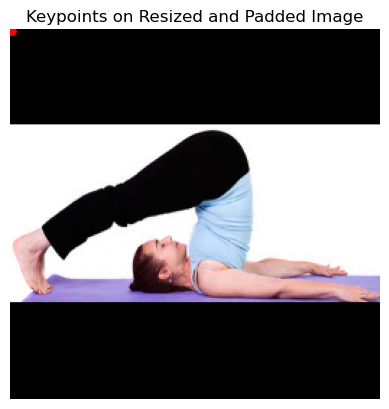

Keypoints plotted.
Plotting keypoints on Keypoints on Original Image image...
Keypoint 0: (x: 176.63733407855034, y: 132.42054264719894, confidence: 0.001945936237461865)
Keypoint 1: (x: 178.9778689146042, y: 152.8291248848768, confidence: 0.0010003290371969342)
Keypoint 2: (x: 575.595405459404, y: 29.587878219480437, confidence: 0.005366848781704903)
Keypoint 3: (x: 371.1145570278168, y: 178.49177166698425, confidence: 0.012995782308280468)
Keypoint 4: (x: 383.2142916917801, y: 197.35065342352644, confidence: 0.010575566440820694)
Keypoint 5: (x: 157.77112686634064, y: 186.45656132891895, confidence: 0.0020304692443460226)
Keypoint 6: (x: 353.91281294822693, y: 235.4535343821456, confidence: 0.011695164255797863)
Keypoint 7: (x: 221.44164815545082, y: 200.77957624730058, confidence: 0.0070513514801859856)
Keypoint 8: (x: 213.38301900029182, y: 138.5162919207317, confidence: 0.003277797484770417)
Keypoint 9: (x: 268.8257270157337, y: 222.46047998443854, confidence: 0.003492554882541299

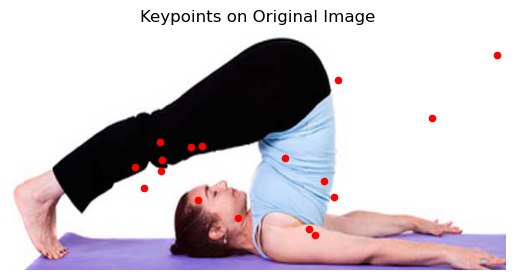

Keypoints plotted.


In [35]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load MoveNet Thunder model from TensorFlow Hub
model_url = "https://tfhub.dev/google/movenet/singlepose/thunder/4"
print("Loading MoveNet Thunder model...")
movenet = hub.load(model_url)
print("MoveNet Thunder model loaded successfully.")

# Function to load and preprocess image while maintaining aspect ratio
def load_and_preprocess_image(image_path):
    print(f"Loading image from path: {image_path}")
    # Read the image from file
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be read.")
    print("Image loaded successfully.")
    
    # Convert image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("Image converted to RGB.")
    
    # Get original image dimensions
    original_h, original_w, _ = image.shape
    print(f"Original image size: {original_w}x{original_h}")
    
    # Resize the image to maintain aspect ratio and fit within 256x256
    input_size = 256
    if original_h > original_w:
        new_h = input_size
        new_w = int(input_size * original_w / original_h)
    else:
        new_w = input_size
        new_h = int(input_size * original_h / original_w)
    
    resized_image = cv2.resize(image, (new_w, new_h))
    print(f"Resized image to: {new_w}x{new_h}")
    
    # Pad the resized image to be 256x256
    pad_h = (input_size - new_h) // 2
    pad_w = (input_size - new_w) // 2
    padded_image = cv2.copyMakeBorder(resized_image, pad_h, input_size - new_h - pad_h, pad_w, input_size - new_w - pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    print(f"Image padded to 256x256 with pad_w={pad_w} and pad_h={pad_h}.")
    
    # Normalize the image to [0,1] and convert to float32
    padded_image = padded_image.astype(np.float32) / 255.0
    print("Image normalized to [0, 1].")
    
    return padded_image, original_h, original_w, pad_h, pad_w, input_size, new_w, new_h

# Function to detect keypoints
def detect_keypoints(image):
    print("Converting image to tensor...")
    input_image = tf.convert_to_tensor(image, dtype=tf.int32)
    input_image = tf.expand_dims(input_image, axis=0)
    print("Running MoveNet Thunder model...")
    outputs = movenet.signatures['serving_default'](input_image)
    keypoints = outputs['output_0'].numpy().reshape(-1)
    print("Keypoints detected.")
    return keypoints

# Function to convert keypoints to original image size
def convert_keypoints(keypoints, original_h, original_w, pad_h, pad_w, input_size, new_w, new_h):
    scale_x = original_w / new_w
    scale_y = original_h / new_h
    converted_keypoints = []
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        x = (x * input_size - pad_w) * scale_x
        y = (y * input_size - pad_h) * scale_y
        converted_keypoints.extend([x, y, conf])
    return np.array(converted_keypoints)

# Function to plot keypoints on image
def plot_keypoints(image, keypoints, title, threshold=0):
    print(f"Plotting keypoints on {title} image...")
    plt.imshow(image)
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        print(f"Keypoint {i//3}: (x: {x}, y: {y}, confidence: {conf})")
        if conf > threshold:  # Only plot keypoints with high confidence
            plt.scatter(x, y, s=20, c='r', marker='o')
    plt.title(title)
    plt.axis('off')
    plt.show()
    print("Keypoints plotted.")

# Path to the image
image_path = '../data/images/Plow/Plow_Pose_12.png'

# Load and preprocess image
image, original_h, original_w, pad_h, pad_w, input_size, new_w, new_h = load_and_preprocess_image(image_path)

# Extract keypoints
keypoints = detect_keypoints(image)

# Convert keypoints to original image size
converted_keypoints = convert_keypoints(keypoints, original_h, original_w, pad_h, pad_w, input_size, new_w, new_h)

# Print keypoints before and after conversion to original size
print("\nKeypoints before conversion to original size:")
for i in range(0, len(keypoints), 3):
    x, y, conf = keypoints[i:i+3]
    print(f"Keypoint {i//3}: (x: {x}, y: {y}, confidence: {conf})")

print("\nKeypoints after conversion to original size:")
for i in range(0, len(converted_keypoints), 3):
    x, y, conf = converted_keypoints[i:i+3]
    print(f"Keypoint {i//3}: (x: {x}, y: {y}, confidence: {conf})")

# Plot keypoints on the resized and padded image
plot_keypoints(image, keypoints, title="Keypoints on Resized and Padded Image")

# Plot keypoints on the original image
original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plot_keypoints(original_image, converted_keypoints, title="Keypoints on Original Image")
